In [1]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, TimeDistributed, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import os
from keras.models import load_model
from keras.callbacks import Callback
import json
import io
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
from comet_ml import Experiment

In [ ]:
# # establecer semilla
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# Levanto datos crudos por sujeto

In [ ]:
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/datasets"  # TODO cambiar ruta

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/datasets


In [ ]:
# levanto todos los datasets
cant_ds = 40
list_ds = []
for i in range(cant_ds):
  ds = tf.data.Dataset.load("dataset_GI_sin_reposo_650_stride5_crudo_sub"+str(i))
  list_ds.append(ds)

## 5 particiones
Hago una función para generar particiones aleatorias

In [ ]:
def generar_particion_sin_test(list_ds, ind_train, ind_val):

  ds_train = list_ds[ind_train[0]]
  ind_train = ind_train[1:]  # porque inicializo el dataset con este

  for i in ind_train:
    ds_train = ds_train.concatenate(list_ds[i])

  ds_val = list_ds[ind_val[0]]
  ind_val = ind_val[1:]  # porque inicializo el dataset con este
  for i in ind_val:
    ds_val = ds_val.concatenate(list_ds[i])

  return ds_train, ds_val

In [ ]:
def generar_particion(list_ds, ind_train, ind_val, ind_test):

  ds_train = list_ds[ind_train[0]]
  ind_train = ind_train[1:]  # porque inicializo el dataset con este

  for i in ind_train:
    ds_train = ds_train.concatenate(list_ds[i])

  ds_val = list_ds[ind_val[0]]
  ind_val = ind_val[1:]  # porque inicializo el dataset con este
  for i in ind_val:
    ds_val = ds_val.concatenate(list_ds[i])

  ds_test = list_ds[ind_test[0]]
  ind_test = ind_test[1:]  # porque inicializo el dataset con este
  for i in ind_test:
    ds_test = ds_test.concatenate(list_ds[i])

  return ds_train, ds_val, ds_test


In [ ]:
# con test
indices = np.random.permutation(40)
ind_train = indices[:30]
ind_val = indices[30:35]
ind_test = indices[35:40]

ds_train_base, ds_val_base, ds_test_base = generar_particion(list_ds, ind_train, ind_val, ind_test)

In [ ]:
# sin test
indices = np.random.permutation(40)
ind_train = indices[:35]
ind_val = indices[35:]


ds_train_base, ds_val_base = generar_particion_sin_test(list_ds, ind_train, ind_val)

In [ ]:
print(ind_train)
print(ind_val)
print(ind_test)

In [ ]:
print(ind_train)
print(ind_val)

[35  0 18 33 27 16  8 10  9 20 19 25  1 15 36 22 26  6 34  7 14 31  3 23
 11  2  4 12 30 28 17 32  5 38 37]
[21 29 13 39 24]


Creo un directorio para guardar los modelos y otras cosas relativos al entrenamiento de este modelo.

# Accedo a experimento guardado

In [ ]:
# elijo el directorio donde quiero guardar los resultados del experimento actual
nombre_exp = "GI_estrategia1_normalizado_DB2_particion1"
ruta_experimento = "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/" + nombre_exp  # TODO cambiar ruta
os.makedirs(ruta_experimento, exist_ok=True) # me fijo si existe, si no, lo creo
os.chdir(ruta_experimento) # me situo en el directorio

In [ ]:
# levanto los indices
ind_train = joblib.load("ind_train_" + nombre_exp)
ind_val = joblib.load("ind_val_" + nombre_exp)
ind_test = joblib.load("ind_test_" + nombre_exp)

ds_train_base, ds_val_base, ds_test_base = generar_particion(list_ds, ind_train, ind_val, ind_test)

In [ ]:
# levanto los indices
ind_train = joblib.load("ind_train_" + nombre_exp)
ind_val = joblib.load("ind_val_" + nombre_exp)
# ind_test = joblib.load("ind_test_" + nombre_exp)

ds_train_base, ds_val_base = generar_particion_sin_test(list_ds, ind_train, ind_val)

In [ ]:
print(ind_train)
print(ind_val)

[30  5  0  9 16 10  7 24 26 25  4 32 36 17 21 39 11 13 14 19 23  1 22 34
  6 33 37 18 12 29  3 31 20  8 38]
[15  2 27 28 35]


In [ ]:
# levanto los indices
ind_train = joblib.load("ind_train_" + nombre_exp)
ind_val = joblib.load("ind_val_" + nombre_exp)
# ind_test = joblib.load("ind_test_" + nombre_exp)
print(ind_train)
print(ind_val)

ds_train_base, ds_val_base = generar_particion_sin_test(list_ds, ind_train, ind_val)

[30  5  0  9 16 10  7 24 26 25  4 32 36 17 21 39 11 13 14 19 23  1 22 34
  6 33 37 18 12 29  3 31 20  8 38]
[15  2 27 28 35]


In [ ]:
# guardo los indices
joblib.dump(ind_train, 'ind_train_' + nombre_exp)
joblib.dump(ind_val, 'ind_val_' + nombre_exp)
# joblib.dump(ind_test, 'ind_test_' + nombre_exp)

['ind_val_GI_estrategia1_normalizado_DB2_particion1']

In [ ]:
del list_ds

In [ ]:
del ds

# Aplicar scaler

In [ ]:
# vuelvo al directorio de los datasets
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/datasets"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/datasets


In [ ]:
largo_ds = tf.data.experimental.cardinality(ds_train_base).numpy()

In [ ]:

for x, y in ds_train_base.take(1):
  print(type(x.numpy()[0, 0]))

<class 'numpy.float32'>


In [ ]:
X_train = np.zeros((largo_ds, 650, 12), dtype=np.float32)
y_train = np.zeros((largo_ds), dtype = np.uint8)

In [ ]:
i = 0
for data_i, labels_i in ds_train_base:
  X_train[i] = data_i.numpy()  # Convertir características a NumPy
  y_train[i] = labels_i.numpy()      # Convertir etiquetas a NumPy
  i += 1

In [ ]:
# train
data_train_list = []
labels_train_list = []

for data_i, labels_i in ds_train_base:
    data_train_list.append(data_i.numpy())  # Convertir características a NumPy
    labels_train_list.append(labels_i.numpy())      # Convertir etiquetas a NumPy

# # val
# data_val_list = []
# labels_val_list = []

# for data_i, labels_i in ds_val_base:
#     data_val_list.append(data_i.numpy())  # Convertir características a NumPy
#     labels_val_list.append(labels_i.numpy())      # Convertir etiquetas a NumPy

# # test
# data_test_list = []
# labels_test_list = []

# for data_i, labels_i in ds_test_base:
#     data_test_list.append(data_i.numpy())  # Convertir características a NumPy
#     labels_test_list.append(labels_i.numpy())      # Convertir etiquetas a NumPy

In [ ]:
X_train = np.array(data_train_list)
y_train = np.array(labels_train_list)
del data_train_list
del labels_train_list
# X_val = np.array(data_val_list)
# y_val = np.array(labels_val_list)
# X_test = np.array(data_test_list)
# y_test = np.array(labels_test_list)

In [ ]:
del ds_train_base

In [ ]:
del list_ds

In [ ]:
del ds_val_base
del data_i

In [ ]:
sys.getsizeof(X_train)/(1024*1024*1024)

4.946156725287437

In [ ]:
sys.getsizeof(y_train)/(1024*1024)

0.16244220733642578

In [ ]:
del ds

In [ ]:
# hacer directamente sobre el X_train, sin pipeline
mean_X_train = np.mean(X_train, axis = 1)
mean_X_train = np.mean(mean_X_train, axis = 0)

In [ ]:
print(mean_X_train)

[-0.00218728  0.00023408 -0.00750704 -0.00421415 -0.00077261  0.00013716
  0.00160238  0.00154742 -0.00226092  0.00219881  0.00017859  0.00207524]


In [ ]:
# hacer directamente sobre el X_train, sin pipeline
std_X_train = np.std(X_train, axis = 1)
std_X_train = np.max(np.max(std_X_train, axis = 0))

In [ ]:
# X_train = X_train - mean_X_train.reshape(12, 1)

for i in range(X_train.shape[0]):
  for j in range(X_train.shape[1]):
    X_train[i, j, :] -= mean_X_train


In [ ]:
# hacer directamente sobre el X_train, sin pipeline
mean_X_train = np.mean(X_train, axis = 1)
mean_X_train = np.mean(mean_X_train, axis = 0)

In [ ]:
X_train /= std_X_train

In [ ]:
print(mean_X_train)

[ 1.9695070e-08 -9.7585309e-09  1.4852522e-08  2.3218137e-08
 -2.7378710e-09 -3.2427145e-09  5.0579296e-09  1.3404693e-08
  2.4708402e-08 -6.1011338e-09 -2.7332203e-09 -1.1429661e-08]


In [ ]:


# Crear una matriz de ejemplo (3 filas, 3 columnas)
matriz = np.array([[[1, 2, 3],
                   [4, 5, 6],
                   [4, 5, 6],
                   [7, 8, 9]],
                  [[1, 2, 3],
                   [4, 5, 6],
                   [4, 5, 6],
                   [7, 8, 9]]]
                  )

# Crear un vector fila de 3 elementos
vector = np.array([10, 20, 30, 1])

# Sumar el vector a cada fila de la matriz
resultado = matriz + vector.reshape(4, 1)

print(resultado)


[[[11 12 13]
  [24 25 26]
  [34 35 36]
  [ 8  9 10]]

 [[11 12 13]
  [24 25 26]
  [34 35 36]
  [ 8  9 10]]]


In [ ]:
# Crear el escalador personalizado heredando de BaseEstimator y TransformerMixin
class MaxStdScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Calcular la desviación estándar por canal (columna)
        self.std_per_channel_ = np.std(X, axis=0)
        # Obtener la desviación estándar máxima
        self.max_std_ = np.max(self.std_per_channel_)
        return self

    def transform(self, X):
        # Dividir todas las características por la desviación estándar máxima
        return X / self.max_std_

# Crear el pipeline
pipeline = Pipeline([
    ('scaler', MaxStdScaler())
])

# Aplicar el pipeline (escalador personalizado)
scaled_X_train = pipeline.fit_transform(X_train, y_train)

# Convertir las características escaladas y etiquetas a tf.data.Dataset
scaled_ds_train = tf.data.Dataset.from_tensor_slices((scaled_X_train, y_train))

# # Aplicar el pipeline (escalador personalizado)
# scaled_X_val = pipeline.transform(X_val)

# # Convertir las características escaladas y etiquetas a tf.data.Dataset
# scaled_ds_val = tf.data.Dataset.from_tensor_slices((scaled_X_val, y_val))

# # Aplicar el pipeline (escalador personalizado)
# scaled_X_test = pipeline.transform(X_test)

# # Convertir las características escaladas y etiquetas a tf.data.Dataset
# scaled_ds_test = tf.data.Dataset.from_tensor_slices((scaled_X_test, y_test))

In [ ]:
# elimino variables innecesarias
del X_train
# del X_val
del y_train
# del y_val
# del data_train_list
# del labels_train_list

# Preparación de datos

In [ ]:
# Directorio de los datos
%cd "/content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/datasets"

/content/drive/.shortcut-targets-by-id/1p7dFFKqLvO4o4GAmIQpnbXVWvt_2Dv-l/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/datasets


In [ ]:
for x, y, z in ds_train_base.take(1):
  input_shape = x.shape
  label_shape = y.shape
  label = y
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Label', label)

num_classes = 10

Input shape: (650, 12)
Label shape: ()
Label tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
# Función para convertir etiquetas a formato one-hot
def one_hot_encode(features, label, weight):
    label = tf.one_hot(label, depth=num_classes)
    return features, label, weight

In [ ]:
# funciones de acondicionamiento de los datos
BATCH_SIZE = 16
def preparar_ds(ds):
  ds = ds.map(one_hot_encode) # paso las clases a una codificacion one hot
  ds = ds.shuffle(buffer_size=ds.cardinality()) # hago un shuffle de los datos
  ds = ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # armo batches y cargo en memoria la cantidad de datos optima, listos para ser utilizados
  return ds

ds_train = preparar_ds(ds_train_base)
ds_val = preparar_ds(ds_val_base)
# ds_test = preparar_ds(ds_test_base)


# Diseño e implementación de RNN

In [ ]:
# opcional para liberar memoria
del ds_train_base
del ds_val_base

## Arquitectura simple
Solo una capa recurrente.

In [ ]:
input_shape = (650, 12)
# Definir el modelo con return_sequences=True
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(48, input_shape=input_shape, return_sequences=True),  # Devuelve la secuencia completa
    tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para la clasificación
])
lr = 0.00008
# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

# Resumen del modelo
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 650, 48)             │          11,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 48)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,202 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

## Arquitectura más compleja
Le agrego una capa densa y aumento la cantidad de neuronas de la recurrente.

In [ ]:
input_shape = (400, 16)
# Definir el modelo con return_sequences=True
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(72, input_shape=input_shape, return_sequences=True),  # Devuelve la secuencia completa
    # tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.TimeDistributed(Dense(64, activation='relu')),
    tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para la clasificación
])
lr = 0.00005
# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 400, 72)             │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 400, 64)             │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,564 (119.39 KB)

 Trainable params: 30,564 (119.39 KB)

 Non-trainable params: 0 (0.00 B)

## Si entreno el modelo por primera vez

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{self.epoch_offset + epoch + 1}.keras')
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Crear el callback
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento)

# Entrenar el modelo
history = model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=[saver])

Epoch 1/10
10638/10639 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4105 - loss: 1.8038Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/model_epoch_1.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/complete_history.json
10639/10639 ━━━━━━━━━━━━━━━━━━━━ 518s 40ms/step - accuracy: 0.4106 - loss: 1.8037 - val_accuracy: 0.5376 - val_loss: 1.3656
Epoch 2/10
10639/10639 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6226 - loss: 1.1775Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/model_epoch_2.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/complete_history

<Axes: xlabel='Epoch'>

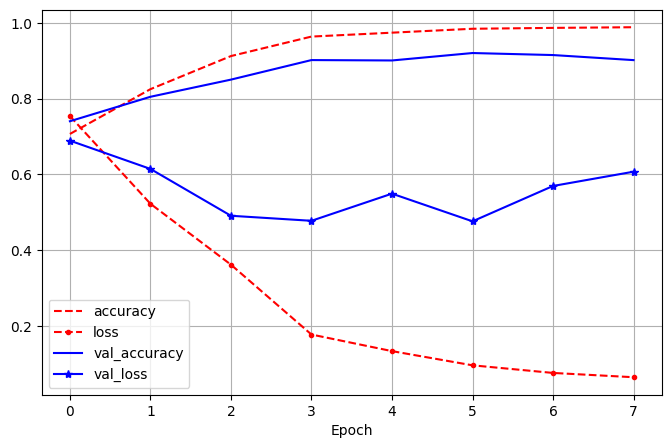

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(history.history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

## Si quiero retomar el entrenamiento

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_6.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

# AJUSTAR LA EPOCA EN LA QUE RETOMO EL ENTRENAMIENTO
# Continuar el entrenamiento desde la última época. En initial_epoch pongo el numero de la ultima epoca entrenada
model.fit(ds_train, validation_data=ds_val, epochs=8, initial_epoch=6, callbacks=[saver])

Epoch 7/8
10639/10639 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7888 - loss: 0.6326Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/model_epoch_7.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/complete_history.json
10639/10639 ━━━━━━━━━━━━━━━━━━━━ 333s 22ms/step - accuracy: 0.7888 - loss: 0.6326 - val_accuracy: 0.6890 - val_loss: 0.9554
Epoch 8/8
10639/10639 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8088 - loss: 0.5854Modelo guardado en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/model_epoch_8.keras
Historia de entrenamiento guardada en /content/drive/My Drive/repo_tesis/src/ronda_gestos_puntuales/10_gestos/DB2/modelos/GI_estrategia1_normalizado_DB2_particion1/complete_history.j

## Si el modelo está entrenado

In [ ]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# ELIJO QUE EPOCA QUIERO USAR, PUEDO MIRAR LA GRAFICA Y ELEGIR LA MEJOR
# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_5.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

<Axes: xlabel='Epoch'>

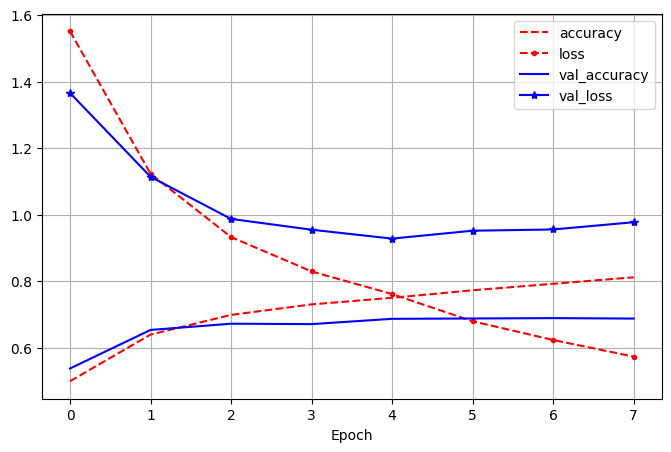

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

# Adaptación para hacer los evaluate
Para ejecutar esta parte tengo que tener el modelo entrenado y los dataset base cargados en memoria. Si el modelo ya está entrenado tengo que ejecutar la celda correspondiente.

## Cálculo de predicciones

In [ ]:
# armo batches en los conjuntos para poder realizar predicciones
ds_train_batch = ds_train_base.batch(16)
ds_val_batch = ds_val_base.batch(16)
# ds_test_batch = ds_test_base.batch(16)

In [ ]:
# Obtener las predicciones en 1hot
y_pred_train_1hot = model.predict(ds_train_batch)
y_pred_val_1hot = model.predict(ds_val_batch)
# y_pred_test_1hot = model.predict(ds_test_batch)

10639/10639 ━━━━━━━━━━━━━━━━━━━━ 137s 13ms/step
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step


Se puede ver que las predicciones no quedaron organizadas en batches, pero sí devuelven un vector codificado en one hot.

In [ ]:
def onehot2numerical(y_pred):
  # Convertir de one-hot a clases numéricas las predicciones
  y_clases = tf.argmax(y_pred, axis=-1)
  # Convertir a numpy si es necesario
  y_clases_numpy = y_clases.numpy()
  return y_clases_numpy

y_pred_train = onehot2numerical(y_pred_train_1hot)
y_pred_val = onehot2numerical(y_pred_val_1hot)
# y_pred_test = onehot2numerical(y_pred_test_1hot)

## Extracción de etiquetas reales

In [ ]:
def extraer_etiquetas_ds(ds):
  y_train_true_list = []
  for x, y, z in ds: # dataset_with_classes ds_train
    # print(y.shape)
    y_train_true_list.append(y.numpy())
  return y_train_true_list

y_true_train_list = extraer_etiquetas_ds(ds_train_base)
y_true_val_list = extraer_etiquetas_ds(ds_val_base)
# y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
y_true_train_array = np.array(y_true_train_list)
y_true_val_array = np.array(y_true_val_list)
# y_true_test_array = np.array(y_true_test_list)

# print(y_true_train_array.shape)

In [ ]:
# Visualizacion de ejemplo
y_true_train_list[2]

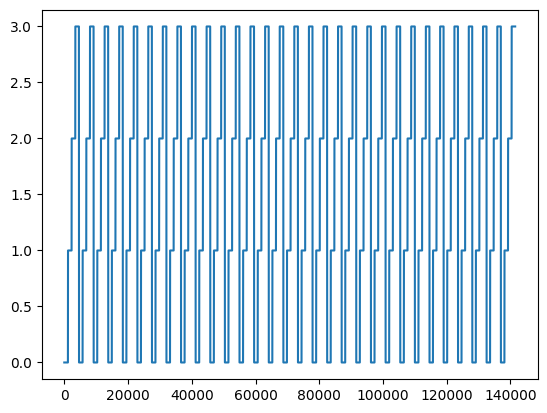

In [ ]:
plt.figure()
plt.plot(y_true_val_array)

# Matrices de confusión

In [ ]:
os.chdir(ruta_experimento) # me situo en el directorio

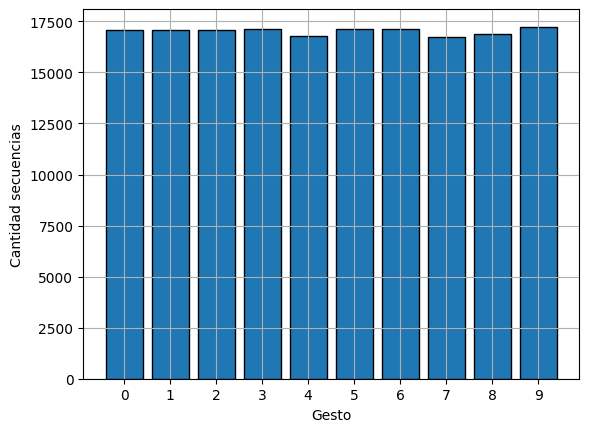

In [ ]:
# Crear los bordes de los bins para que estén centrados en 0, 1, ..., 9
bins = np.arange(-0.5, 10.5, 1)

# Generar el histograma
plt.hist(y_true_train_array, bins=bins, edgecolor='black', rwidth=0.8)
plt.grid(True)
plt.xticks(np.arange(10))  # Asegurarse de que los ticks estén en los enteros de 0 a 9
plt.xlabel('Gesto')
plt.ylabel('Cantidad secuencias')
plt.savefig('cantidad_gestos.png')
plt.show()

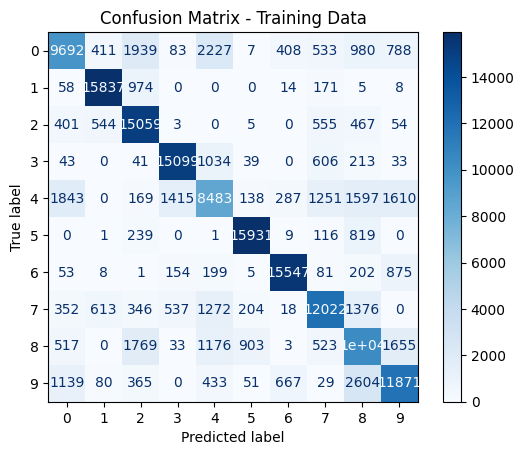

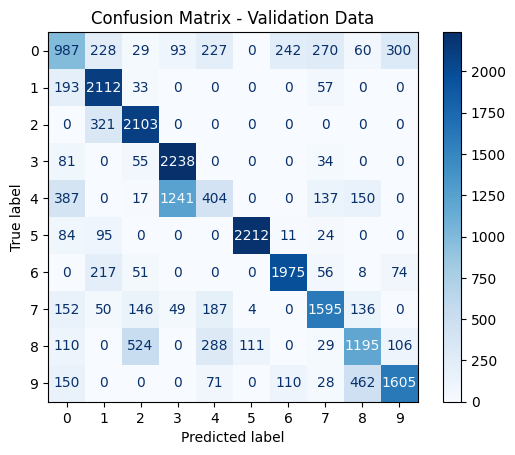

In [ ]:
# Generar matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_true_train_array, y_pred_train)
ConfusionMatrixDisplay(conf_matrix_train).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Training Data')
plt.savefig('train.png')
plt.show()

# Generar matriz de confusión para el conjunto de validación
conf_matrix_val = confusion_matrix(y_true_val_array, y_pred_val)
ConfusionMatrixDisplay(conf_matrix_val).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.savefig('val.png')
plt.show()

# # para test

# # Generar matriz de confusión para el conjunto de entrenamiento
# conf_matrix_test = confusion_matrix(y_true_test_array, y_pred_test)
# ConfusionMatrixDisplay(conf_matrix_test).plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Test Data')
# plt.savefig('test.png')
# plt.show()

Accuracy en entrenamiento: 0.7628


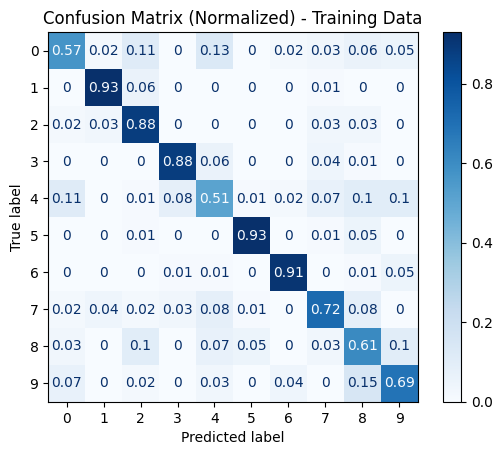

Accuracy en validación: 0.6869


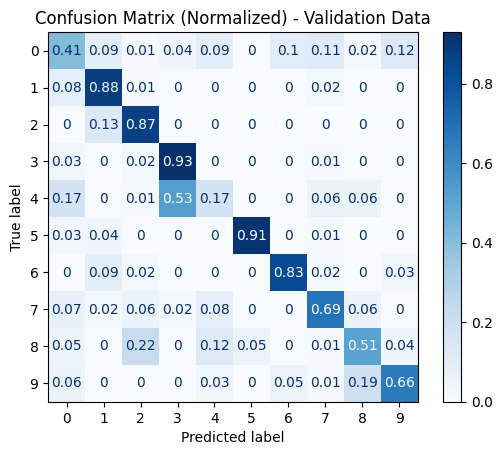

In [ ]:
# Función para generar y guardar la matriz de confusión con proporciones redondeadas
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2):
    # Generar la matriz de confusión normalizada (por clase)
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

    # Redondear la matriz a la cantidad de decimales especificados
    conf_matrix = np.round(conf_matrix, decimals=decimales)

    # Crear el display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Graficar
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)

    # Guardar la figura
    plt.savefig(ruta_guardar)
    plt.show()

# Función para calcular y mostrar el accuracy
def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy

# Para el conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train, 'Confusion Matrix (Normalized) - Training Data', 'train_normalized.png')

# Para el conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val, 'Confusion Matrix (Normalized) - Validation Data', 'val_normalized.png')

# # Para el conjunto de test
# accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
# generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test, 'Confusion Matrix (Normalized) - Test Data','test_normalized.png')


# Guardar experimento en Comet

In [ ]:
joblib.dump(conf_matrix_train, "cm_train_"+nombre_exp+".pkl")
joblib.dump(conf_matrix_val, "cm_val_"+nombre_exp+".pkl")
# joblib.dump(conf_matrix_test, "cm_test_"+nombre_exp+".pkl")

['cm_val_GI_estrategia1_normalizado_DB2_particion1.pkl']

In [ ]:
# Guardar resumen en una cadena de texto para guardarlo en Comet
stream = io.StringIO()
model.summary(print_fn=lambda x: stream.write(x + '\n'))
summary_str = stream.getvalue()
stream.close()

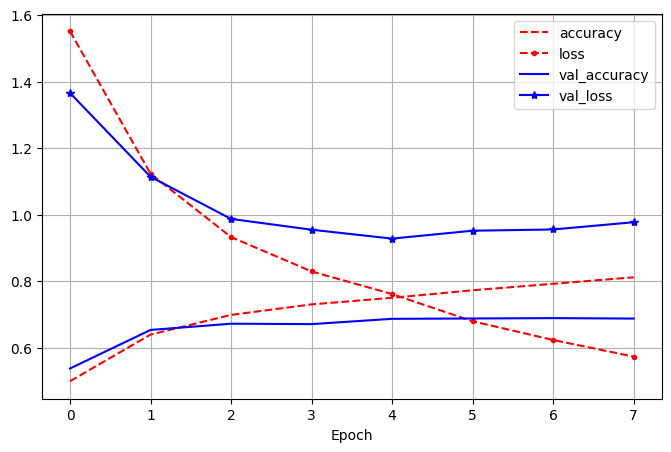

In [ ]:
nombre = nombre_exp
joblib.dump(model, nombre + '.pkl')
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.png")

In [ ]:
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
              project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
              auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['ronda_GI','estrategia1', '10_gestos','seq_vector', 'x_sujeto']) # Tags,'particion_1'

# exp.log_metric("test_accuracy_rank", accuracy_test)
exp.log_metric("val_accuracy_rank", accuracy_val)
exp.log_metric("train_accuracy_rank", accuracy_train)

exp.log_parameter("batch_size", BATCH_SIZE)
exp.log_parameter("stride", 5)
exp.log_parameter("largo_secuencia", 650)
exp.log_parameter("stop_epoch", 5)
exp.log_parameter("sample_weight", 0)
exp.log_parameter("porcentaje_label", 100)
exp.log_parameter("cantidad_gestos", 10)
# exp.log_parameter("particion_datos", 1)
exp.log_parameter("sujetos train", ind_train)
exp.log_parameter("sujetos validacion", ind_val)
# exp.log_parameter("sujetos test", ind_test)

exp.log_asset("cm_train_"+nombre_exp+".pkl")
exp.log_asset("cm_val_"+nombre_exp+".pkl")
# exp.log_asset("cm_test_"+nombre_exp+".pkl")

exp.log_parameter("fs", 200)
exp.log_parameter("lr", format(lr, ".8g"))

# Guardar la imagen en Comet
exp.log_image("evolucion_entrenamiento.png")

exp.log_image('train.png')
exp.log_image('val.png')
# exp.log_image('test.png')

exp.log_image('train_normalized.png')
exp.log_image('val_normalized.png')
# exp.log_image('test_normalized.png')

exp.log_text("Estrategia 1 con normalización train sobre DB2.\n")   # Comentario del experimento
exp.log_text("Model Summary:\n" + summary_str)
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorflow, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/410bd87c523546138b289dbca3d8fb45

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : GI_estrategia1_normalizado_DB2_particion1
COMET INFO:     url                